<a href="https://colab.research.google.com/github/gauravcr7rm/cool_name_pending/blob/master/customer_segmentation_with_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I'll use the Online Retail Database which contains one year worth of clients' transactions from an e-commerce website. The objective here is to classify a client as soon as possible so the marketing team can push the right offers to the corresponding clients. 



**PART 1 : Analyze and Clean the dataset**

*     Cleaning the data
*     Exploratory analysis
*     Feature engineering
   
    
**PART 2 : Creating customer categories**

*     Intermediate dataset grouped by invoices
*     Final dataset grouped by customers 
*     K-means clustering
*     Interpreting the clusters
    
    
 **PART 3 : Testing models for predicition**
 
*      Classic sklearn models
*      Random Forest
*      XGBoost
 


** PART 1 : ANALYSE AND CLEAN THE CLUSTERS **

Importing the useful libraries

In [0]:
# Importation of useful libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import random 
import datetime as dt
import re
import pickle
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import digits, punctuation


from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [0]:
cd /content/gdrive/My Drive/Work/

/content/gdrive/My Drive/Work


**1.1 Cleaning the data**

In [0]:
# Importing the database 

data = pd.read_csv("data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [0]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Let's take a look at the missing values

Text(0.5, 1.0, 'Ratio of missing values per columns')

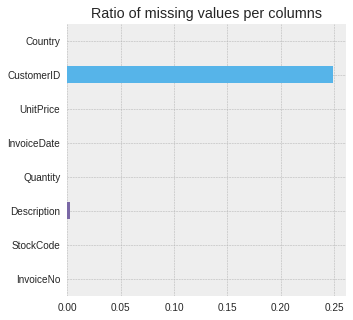

In [0]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

Let's go deeper in these missing values

In [0]:
nan_rows = data[data.isnull().T.any().T]
nan_rows.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


Since the missing values are only in the CustomerID column and the description column, we could try to look at the InvoiceNo and see if maybe we can find the Customer ID

In [0]:
data[data['InvoiceNo']== '536414']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom


In [0]:
data[data['InvoiceNo']== '536544'][:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom


It appears that we can't replace the missing values and we can't keep data without the value in the customer id columns since we want to classify the customers. So I'll drop the lines with missing values on the customer ID column.

In [0]:
data = data.dropna(subset=["CustomerID"])

Text(0.5, 1.0, 'Ratio of missing values per columns')

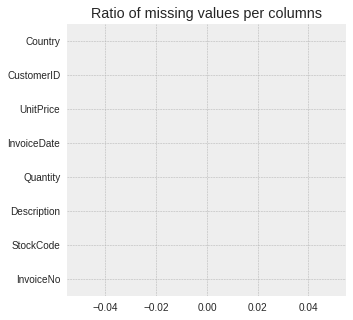

In [0]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

There are no more missing values.
I'll now check the dupplicate values and drop them if there's any. 

In [0]:
print('Dupplicate entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Dupplicate entries: 5225


**1.2 Exploratory Analysis**

**1.2.1 Countries**

In [0]:
data.Country.nunique()

37

In [0]:
customer_country=data[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


More than 90% of the data is coming from UK ! 

**1.2.2 Quantity**

In [0]:
data.describe()

,Quantity,UnitPrice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [0]:
data[(data['Quantity']<0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom


This is very interesting since we can see various things here :
* The stock code values aren't only numerical, there are speciales values like D which means Discount 
* The InvoiceNo aren't also only numerical since there is a C before the other numbers for every negative value in the quantity column, this could mean that the order was canceled.

I'll analyse the InvoiceNo to find any patterns.

**1.2.3 InvoiceNo - Cancelation Code**

This part was inspired by Fabien Daniel's brilliant work in his Notebook on customer segmentation. 

In [0]:
# Constucting a basket for later use
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [0]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

It appears that more than 16% of the transactions were canceled which is significant. Let's take a look at some rows where the transaction was canceled.

In [0]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1][:5]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


In [0]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346,United Kingdom


By looking at these results, it appears that there is a counterpart to the canceled transaction in the database. Let's see if this is always the case.

In [0]:
test = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  test.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(test.loc[index])
        print('Our initial hypothesis is wrong')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
Our initial hypothesis is wrong


In [0]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,12/5/2010 13:17,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/5/2010 13:17,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,12/5/2010 13:17,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,12/5/2010 13:17,3.95,14527,United Kingdom


It appears that when there is a discount there are no counterparts.
Let's try again but without the discount values

In [0]:
data_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  data_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(index, data_check.loc[index])
        print('The second hypothesis is also wrong')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
The second hypothesis is also wrong


In [0]:
data[(data['CustomerID'] == '15311') & (data['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/5/2010 13:55,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/8/2010 13:18,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/13/2010 15:07,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,12/20/2010 15:27,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/5/2011 11:41,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/17/2011 13:39,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2/1/2011 12:14,4.65,15311,United Kingdom


It seels that the customer can also cancel just a part of the transaction which is logical so we need to take this into account for later.

In [0]:
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [0]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 6151
doubtfull_entry: 2607


In [0]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 37


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748,United Kingdom,0
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,12/16/2010 12:56,8.50,14911,EIRE,0
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,12/16/2010 12:56,8.50,14911,EIRE,0
77599,C542744,22700,BLACK AND WHITE DOG BOWL,-10,1/31/2011 16:32,0.85,16191,United Kingdom,0


In [0]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

**1.2.4 Stockcode**

In [0]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

These are specific operations which doesn't characterize our customers so I'll just drop these transactions from our database

In [0]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

**1.2.5 Outliers**

In [0]:
df_cleaned.describe()

,Quantity,UnitPrice,QuantityCanceled
count,391183.000000,391183.000000,391183.000000
mean,13.179665,2.874130,0.583911
std,181.907403,4.284639,175.868790
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,0.000000
50%,6.000000,1.950000,0.000000
75%,12.000000,3.750000,0.000000
max,80995.000000,649.500000,80995.000000


The minimum value for the unitprice is 0, let's see why is that.

In [0]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081,United Kingdom,0


I am tempted to replace the null values by the most common one but it might be a special discount or something else so I'll leave it like that.
Here let's remove the items that got completely canceled in order to harmonize the futur clusters and not have too much special values.

**1.3 Feature engineering**

In [0]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(df_cleaned)

InvoiceNo :  18405
StockCode :  3659
Description :  3871
Quantity :  300
InvoiceDate :  17169
UnitPrice :  356
CustomerID :  4335
Country :  37
QuantityCanceled :  115


**1.3.1 Total Price**

In [0]:
# Total price feature

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

We can now look at the countries' monetary value thanks to this feature

Text(0.5, 1.0, 'Revenue per Country')

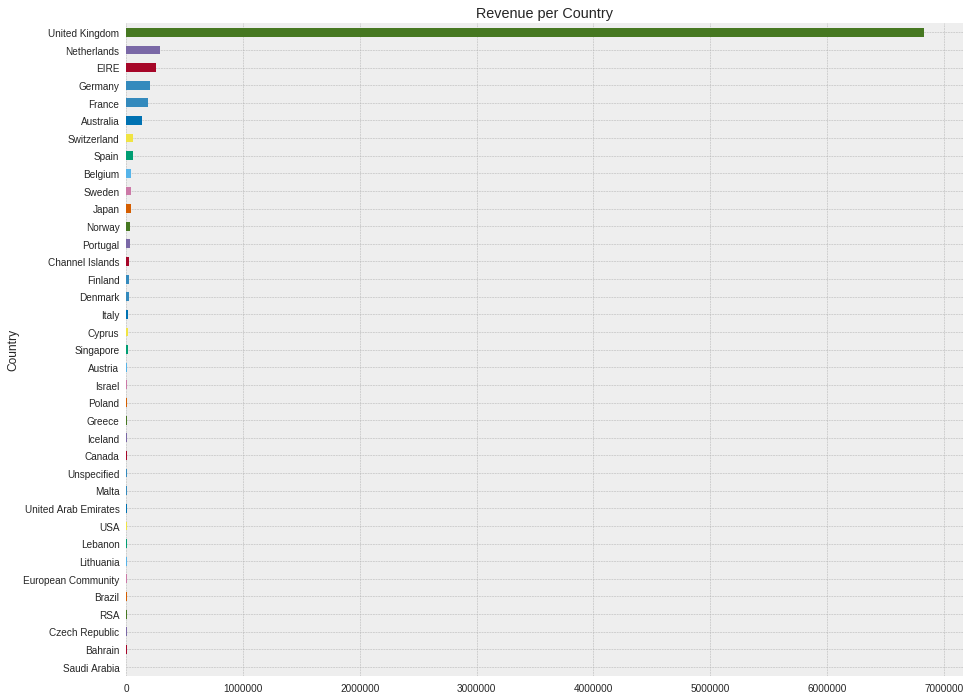

In [0]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")

Text(0.5, 1.0, 'Number of Invoices per Country')

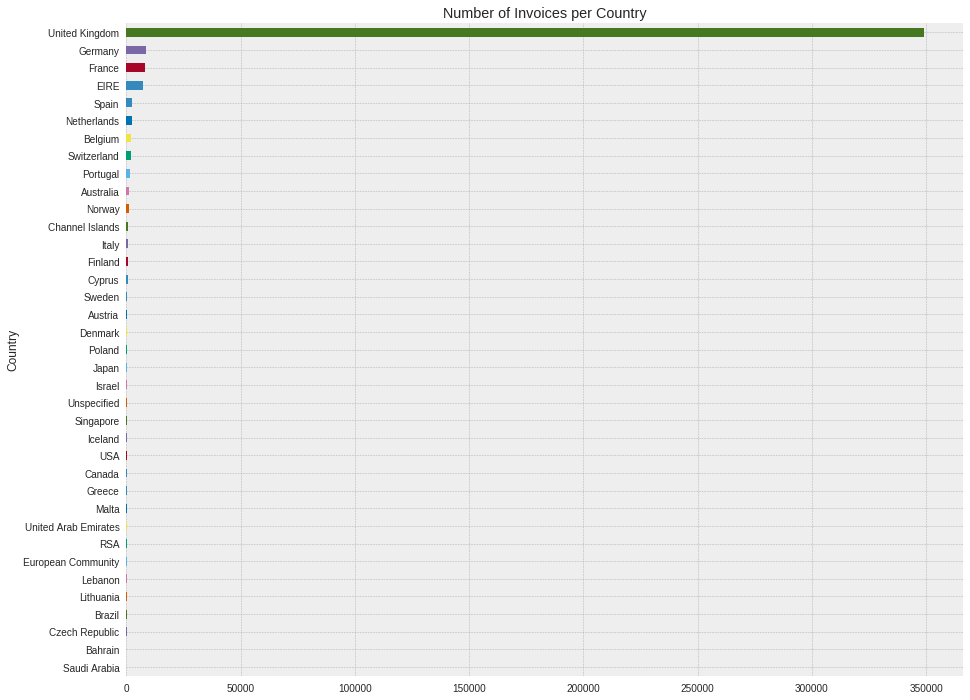

In [0]:
No_invoice_per_country = df_cleaned.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Invoices per Country")

This is very interesting since we can see that Netherlands is the 2nd country in value even though it has less invoices than countries like Germany or France for example and 10 times less customers. (95, 87 and 9 for Germany, France and Netherlands respectively)

In [0]:
le = LabelEncoder()
le.fit(df_cleaned['Country'])

LabelEncoder()

In [0]:
l = [i for i in range(37)]
dict(zip(list(le.classes_), l))

{'Australia': 0,
 'Austria': 1,
 'Bahrain': 2,
 'Belgium': 3,
 'Brazil': 4,
 'Canada': 5,
 'Channel Islands': 6,
 'Cyprus': 7,
 'Czech Republic': 8,
 'Denmark': 9,
 'EIRE': 10,
 'European Community': 11,
 'Finland': 12,
 'France': 13,
 'Germany': 14,
 'Greece': 15,
 'Iceland': 16,
 'Israel': 17,
 'Italy': 18,
 'Japan': 19,
 'Lebanon': 20,
 'Lithuania': 21,
 'Malta': 22,
 'Netherlands': 23,
 'Norway': 24,
 'Poland': 25,
 'Portugal': 26,
 'RSA': 27,
 'Saudi Arabia': 28,
 'Singapore': 29,
 'Spain': 30,
 'Sweden': 31,
 'Switzerland': 32,
 'USA': 33,
 'United Arab Emirates': 34,
 'United Kingdom': 35,
 'Unspecified': 36}

In [0]:
df_cleaned['Country'] = le.transform(df_cleaned['Country'])

In [0]:
with open('labelencoder.pickle', 'wb') as g:
    pickle.dump(le, g)

In [0]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,35,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,35,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,35,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,35,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,35,0,20.34


**1.3.2 RFM Principle**

I'll implement here the RFM principle to classify the customers in this database. This part is inspired by the work of Susan Li. RFM stands for Recency, Frequency and Monetary. It is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

In [0]:
df_cleaned['InvoiceDate'].min()

'1/10/2011 10:32'

In [0]:
df_cleaned['InvoiceDate'].max()

'9/9/2011 9:52'

In [0]:
# I'll just fix the date to be one day after the last entry in the databse

NOW = dt.datetime(2011,12,10)
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [0]:
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["TotalPrice"] = "sum"


rfmTable = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [0]:
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [0]:
rfmTable.head(5)

,InvoiceDate,CustomerID,TotalPrice,Recency
InvoiceNo,,,,
536365,2010-12-01 08:26:00,17850,139.12,373.0
536366,2010-12-01 08:28:00,17850,22.20,373.0
536367,2010-12-01 08:34:00,13047,278.73,373.0
536368,2010-12-01 08:34:00,13047,70.05,373.0
536369,2010-12-01 08:35:00,13047,17.85,373.0


In [0]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["TotalPrice"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(custom_aggregation)

In [0]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [0]:
rfmTable_final.head(5)

,min_recency,max_recency,frequency,monetary_value
CustomerID,,,,
12346,325.0,325.0,1,0.00
12347,2.0,367.0,7,4310.00
12348,75.0,358.0,4,1437.24
12349,18.0,18.0,1,1457.55
12350,310.0,310.0,1,294.40


In [0]:
first_customer = df_cleaned[df_cleaned['CustomerID']=='12747']
first_customer.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
9754,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,35,0,30.60
9755,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05 15:38:00,2.55,12747,35,0,15.30
9756,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05 15:38:00,1.69,12747,35,0,27.04
9757,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05 15:38:00,1.65,12747,35,0,39.60
9758,537215,85064,CREAM SWEETHEART LETTER RACK,6,2010-12-05 15:38:00,5.45,12747,35,0,32.70


The first customer has shopped a lot !

In [0]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [0]:
segmented_rfm = rfmTable_final

In [0]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

Here we'll apply a score on each feature of RFM

In [0]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4
12347,2.0,367.0,7,4310.00,1,1,1
12348,75.0,358.0,4,1437.24,3,2,2
12349,18.0,18.0,1,1457.55,2,4,2
12350,310.0,310.0,1,294.40,4,4,4


Finally we'll set a score for each customer in the database. 

In [0]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1437.24,3,2,2,322
12349,18.0,18.0,1,1457.55,2,4,2,242
12350,310.0,310.0,1,294.40,4,4,4,444


In [0]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
14646,1.0,354.0,73,278742.02,1,1,1,111
18102,0.0,367.0,60,259657.30,1,1,1,111
17450,8.0,367.0,46,193417.63,1,1,1,111
14911,1.0,373.0,198,131009.71,1,1,1,111
14156,9.0,371.0,54,113728.45,1,1,1,111
17511,2.0,373.0,31,88410.13,1,1,1,111
16684,4.0,358.0,28,66072.76,1,1,1,111
13694,3.0,373.0,50,63101.86,1,1,1,111
15311,0.0,373.0,91,59749.33,1,1,1,111


Here we have an example of customers with a score of 111 which means that they are classified as our best customers.

In [0]:
segmented_rfm.head(5)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1437.24,3,2,2,322
12349,18.0,18.0,1,1457.55,2,4,2,242
12350,310.0,310.0,1,294.40,4,4,4,444


In [0]:
segmented_rfm = segmented_rfm.reset_index()

In [0]:
segmented_rfm.head(5)

,CustomerID,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12346,325.0,325.0,1,0.00,4,4,4,444
1,12347,2.0,367.0,7,4310.00,1,1,1,111
2,12348,75.0,358.0,4,1437.24,3,2,2,322
3,12349,18.0,18.0,1,1457.55,2,4,2,242
4,12350,310.0,310.0,1,294.40,4,4,4,444


In [0]:
df_cleaned = pd.merge(df_cleaned,segmented_rfm, on='CustomerID')

In [0]:
df_cleaned.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'QuantityCanceled', 'TotalPrice',
       'min_recency', 'max_recency', 'frequency', 'monetary_value',
       'r_quartile', 'f_quartile', 'm_quartile', 'RFMScore'],
      dtype='object')

We don't need the quartiles anymore, let's drop them.

In [0]:
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

==> Score's definition

![](https://i.imgur.com/YmItbbm.png?)

---



**1.3.3 Time Features**

I'll now create some time features, although I might not use them. It could be interesting to see if there are any paterns due to seasonality.

In [0]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)

In [0]:
df_cleaned['Month'].value_counts()

11    62949
10    48613
12    42536
9     39510
5     27962
6     26820
3     26752
8     26688
7     26476
4     22347
1     20899
2     19631
Name: Month, dtype: int64

In [0]:
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

In [0]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,35,0,15.30,372.0,373.0,34,5322.84,411,12,2,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,35,0,22.00,372.0,373.0,34,5322.84,411,12,2,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8


**1.3.4 Product categories**

In [0]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
X = df_cleaned["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3871, 1694) of float64


In [0]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3871, 100) of float64


In [0]:
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

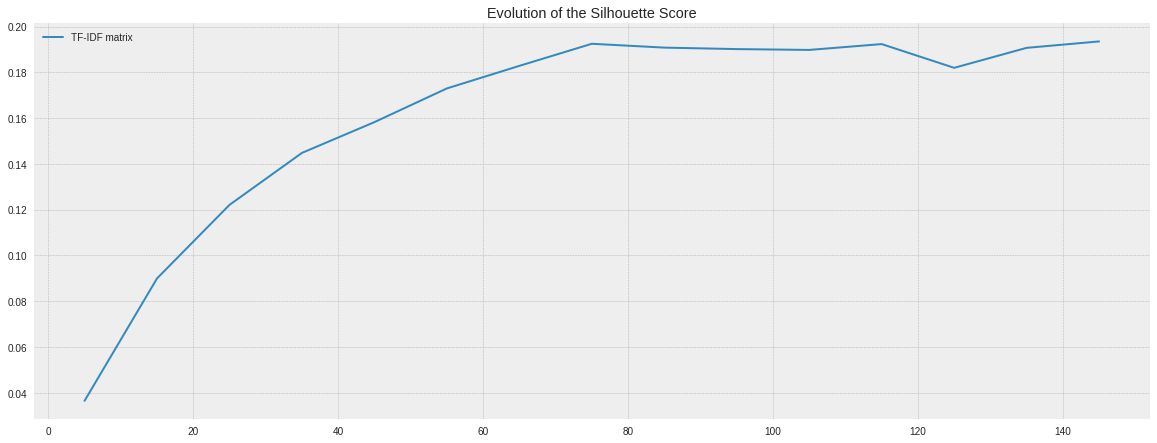

In [0]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

The highest value for the silhouette score is when there are 135 clusters. So we'll chose this value.

Text(0.5, 1.0, 'ACP with 135 clusters')

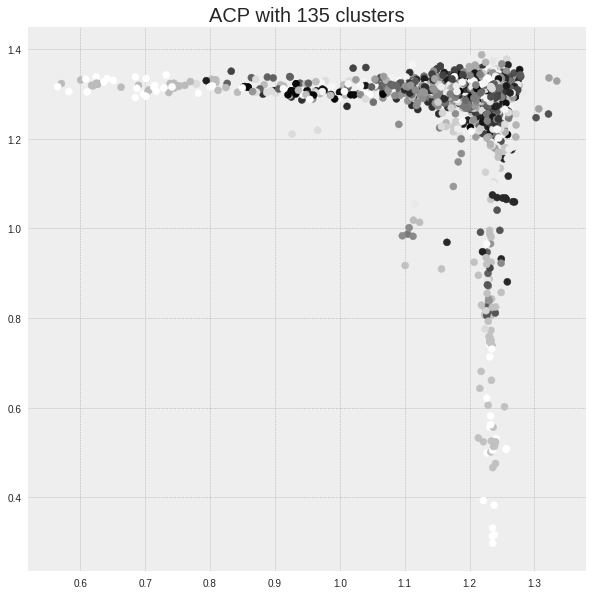

In [0]:
n_clusters = 135

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP with 135 clusters", fontsize="20")

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

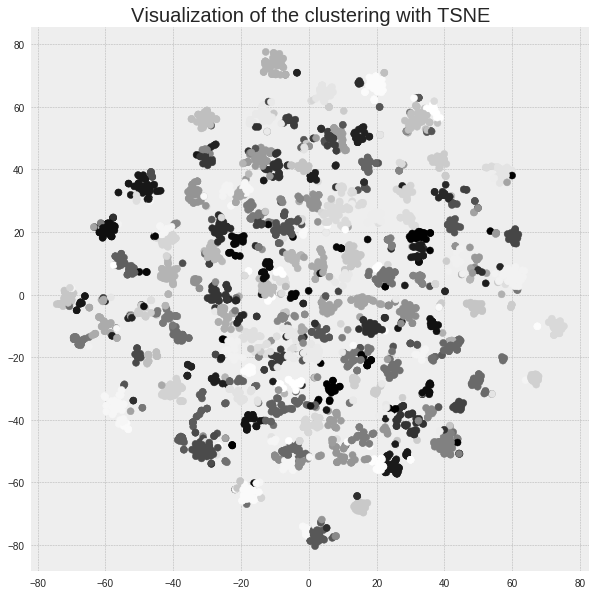

In [0]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")

<Figure size 432x288 with 0 Axes>

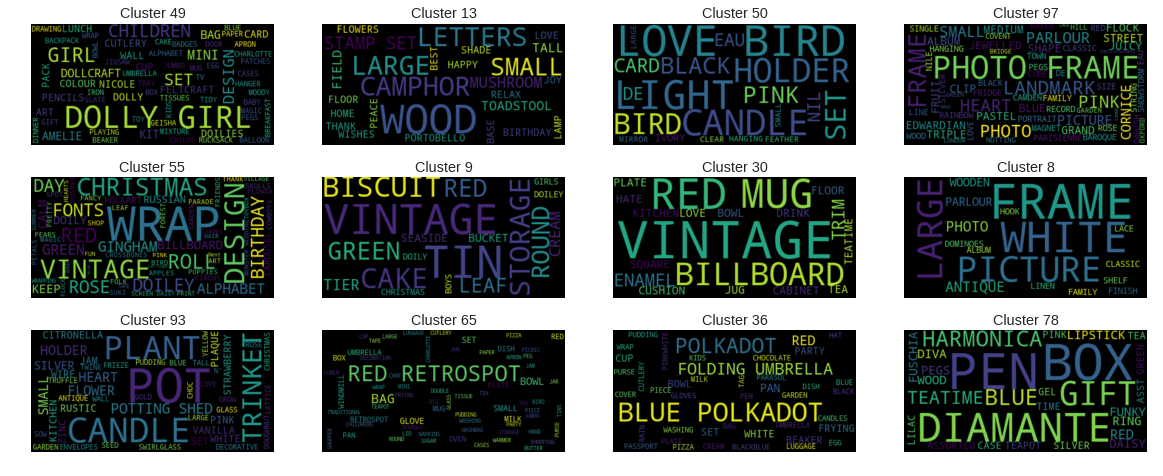

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()

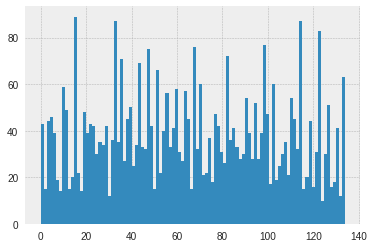

In [0]:
pd.Series(clusters).hist(bins=100)

In [0]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

In [0]:
with open('product_clusters.pickle', 'wb') as h:
    pickle.dump(dict_article_to_cluster, h)

**2. Creating customer categories**

**2.1 Intermediate dataset grouped by invoices**

In [0]:
cluster = df_cleaned['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(df_cleaned["TotalPrice"], 0)
df2 = pd.concat([df_cleaned['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [0]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]


df_grouped = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

**2.2 Final dataset grouped by customers**

In [0]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [0]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [0]:
df_grouped_final.head(5)

TotalPrice                   min_recency max_recency frequency  \
                  min    max       mean    <lambda>    <lambda>  <lambda>   
CustomerID                                                                  
12346             0.0    0.0   0.000000       325.0       325.0         1   
12347            13.2   45.0  23.308571         2.0       367.0         7   
12348            39.6  150.0  82.840000        75.0       358.0         4   
12349            15.0   15.0  15.000000        18.0        18.0         1   
12350            25.2   25.2  25.200000       310.0       310.0         1   

           monetary_value Quantity  Country  
                 <lambda>      sum <lambda>  
CustomerID                                   
12346                0.00    74215       35  
12347             4310.00     2458       16  
12348             1437.24     2332       12  
12349             1457.55      630       18  
12350              294.40      196       24

In [0]:
df_grouped_final.columns = ["min", "max", "mean", "min_recency", "max_recency", "frequency", "monetary_value", "quantity", "country"]

In [0]:
df_grouped_final.head(5)

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country
CustomerID,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16
12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12
12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18
12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24


In [0]:
df2_grouped_final.head(5)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
12347,0.009466,0.0,0.0,0.0,0.006125,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.052343,0.0,0.0,0.000000,0.0,0.0,0.002367,0.0
12348,0.000000,0.0,0.0,0.0,0.000000,0.188862,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
12349,0.000000,0.0,0.0,0.0,0.011320,0.000000,0.0,0.0,0.0,0.011897,...,0.013914,0.0,0.006861,0.0,0.0,0.086282,0.0,0.0,0.018552,0.0
12350,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


**2.3 Clustering customers**

In [0]:
X1 = df_grouped_final.as_matrix()
X2 = df2_grouped_final.as_matrix()

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

In [0]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.8857102018118463 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.859959892060772 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.253930834816519 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.29830975694526646 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.39071034134129246 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.3981965794664732 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.4060819406652127 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.4005902213724777 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.40898413877712836 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.4057869105849313 with Std Scaling


We want to have at least 5, 6 clusters so we won't take 2 or 3 clusters even though they have the highest silhouette scores, 8 clusters would fit the best here. 

In [0]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

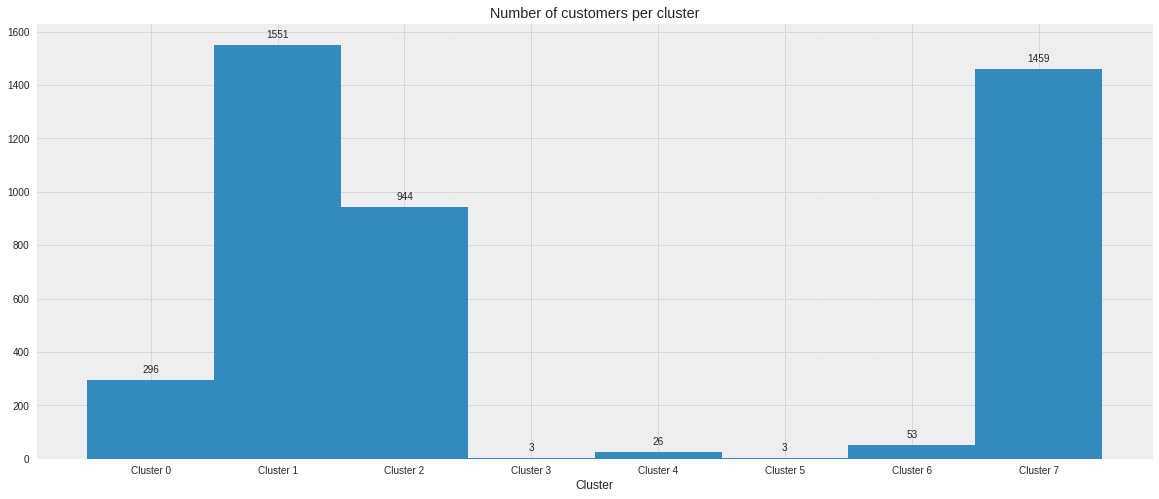

In [0]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [0]:
df_grouped_final["cluster"] = clusters

In [0]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.head()

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35,4,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16,0,...,0.000000,0.0,0.052343,0.0,0.0,0.000000,0.0,0.0,0.002367,0.0
12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12,0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18,0,...,0.013914,0.0,0.006861,0.0,0.0,0.086282,0.0,0.0,0.018552,0.0
12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24,2,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [0]:
final_dataset_V2 = final_dataset.reset_index()

In [0]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

In [0]:
with open('df_cleaned.pickle', 'wb') as f:
    pickle.dump(df_cleaned, f)

**2.3 Interpreting the clusters**

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

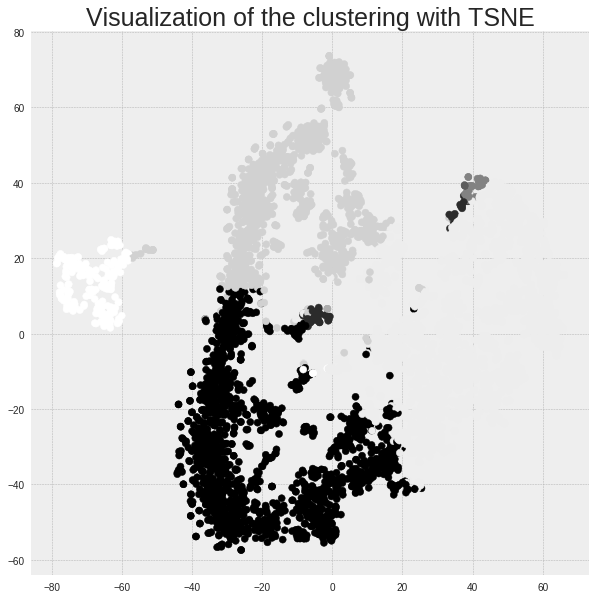

In [0]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")

Graphically the clusters are distinctive enough.
Let's take a closer look at the clusters that contain few customers.

**2.3.1. Cluster 0**

In [0]:
final_dataset[final_dataset['cluster']==0]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,13.20,45.00,23.308571,2.0,367.0,7,4310.00,2458,16,0,...,0.000000,0.0,0.052343,0.0,0.000000,0.000000,0.000000,0.000000,0.002367,0.000000
12348,39.60,150.00,82.840000,75.0,358.0,4,1437.24,2332,12,0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12349,15.00,15.00,15.000000,18.0,18.0,1,1457.55,630,18,0,...,0.013914,0.0,0.006861,0.0,0.000000,0.086282,0.000000,0.000000,0.018552,0.000000
12353,19.90,19.90,19.900000,204.0,204.0,1,89.00,20,2,0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12355,30.00,30.00,30.000000,214.0,214.0,1,459.40,240,2,0,...,0.000000,0.0,0.000000,0.0,0.166522,0.000000,0.000000,0.000000,0.000000,0.000000
12358,15.00,142.80,78.900000,1.0,150.0,2,928.06,242,1,0,...,0.000000,0.0,0.000000,0.0,0.000000,0.098981,0.000000,0.000000,0.000000,0.000000
12359,10.00,34.00,20.175000,57.0,331.0,4,6140.48,1609,7,0,...,0.000000,0.0,0.021790,0.0,0.000000,0.000000,0.009771,0.000000,0.008507,0.002687
12360,10.20,20.80,15.433333,52.0,200.0,3,2302.06,1156,1,0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.016177,0.008471,0.000000,0.009513
12361,23.40,23.40,23.400000,287.0,287.0,1,174.90,90,3,0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [0]:
final_dataset[final_dataset['cluster']==0].mean()

min                 20.476791
max                 60.115101
mean                33.816071
min_recency         91.858108
max_recency        222.472973
frequency            3.905405
monetary_value    1920.305169
quantity          1119.037162
country             11.628378
cluster              0.000000
Cluster_0            0.000873
Cluster_1            0.003251
Cluster_2            0.001616
Cluster_3            0.000041
Cluster_4            0.002186
Cluster_5            0.014582
Cluster_6            0.000678
Cluster_7            0.002303
Cluster_8            0.004716
Cluster_9            0.005056
Cluster_10           0.000903
Cluster_11           0.003797
Cluster_12           0.013914
Cluster_13           0.000560
Cluster_14           0.016834
Cluster_15           0.004216
Cluster_16           0.004742
Cluster_17           0.001591
Cluster_18           0.002702
Cluster_19           0.003304
                     ...     
Cluster_105          0.006413
Cluster_106          0.000898
Cluster_10

In [0]:
temp_final_df = final_dataset.reset_index()

In [0]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['CustomerID'])

In [0]:
cluster0 = df_cleaned[df_cleaned['CustomerID'].isin(cust0)]
cluster0[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity              13.804910
UnitPrice              2.895844
QuantityCanceled       0.119572
TotalPrice            23.689686
frequency              7.883096
min_recency           46.556347
monetary_value      4496.309126
dtype: float64

In [0]:
cluster0['Description'].value_counts()[:10]

ROUND SNACK BOXES SET OF4 WOODLAND     233
REGENCY CAKESTAND 3 TIER               163
PLASTERS IN TIN WOODLAND ANIMALS       151
ROUND SNACK BOXES SET OF 4 FRUITS      147
RED TOADSTOOL LED NIGHT LIGHT          145
PLASTERS IN TIN CIRCUS PARADE          143
SPACEBOY LUNCH BOX                     137
RABBIT NIGHT LIGHT                     120
PLASTERS IN TIN SPACEBOY               120
WOODLAND CHARLOTTE BAG                 111
Name: Description, dtype: int64

In [0]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("CustomerID").agg(custom_aggregation)

In [0]:
cluster0_grouped['RFMScore'].value_counts()

111    32
444    24
211    21
322    17
443    16
321    10
122    10
332    10
343    10
121     9
243     8
342     8
221     8
222     7
344     7
442     6
244     6
433     6
144     6
233     6
132     6
431     5
333     5
223     4
133     4
441     4
432     4
421     3
232     3
231     3
331     3
334     3
123     3
323     3
143     2
112     2
423     2
341     2
311     2
212     1
131     1
142     1
234     1
324     1
242     1
Name: RFMScore, dtype: int64

In [0]:
cluster0_grouped['Country'].value_counts()

14    93
13    86
3     24
18    12
12    12
1      9
6      9
0      8
9      8
7      7
19     6
15     4
5      3
23     3
17     3
22     2
2      2
8      1
11     1
4      1
16     1
10     1
Name: Country, dtype: int64

In [0]:
cluster0['Month'].value_counts()

11    3310
10    3049
9     2184
8     2144
12    2076
6     1893
3     1891
5     1791
7     1757
1     1740
2     1140
4     1019
Name: Month, dtype: int64

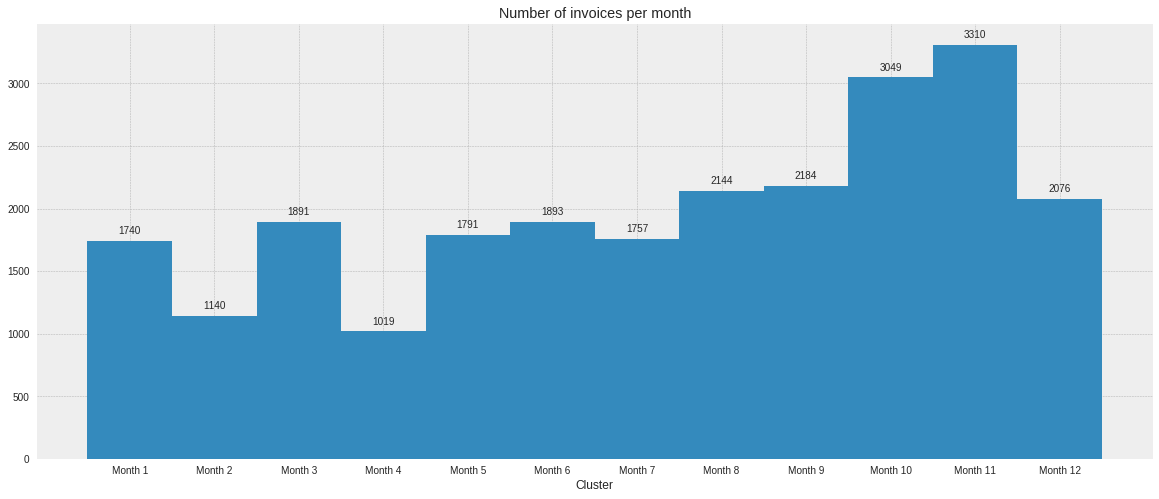

In [0]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [0]:
temp['Year'] = cluster0[cluster0['Month']==12]['InvoiceDate'].map(lambda x: x.year)
temp['Year'].value_counts()

2010.0    56
2011.0    30
Name: Year, dtype: int64

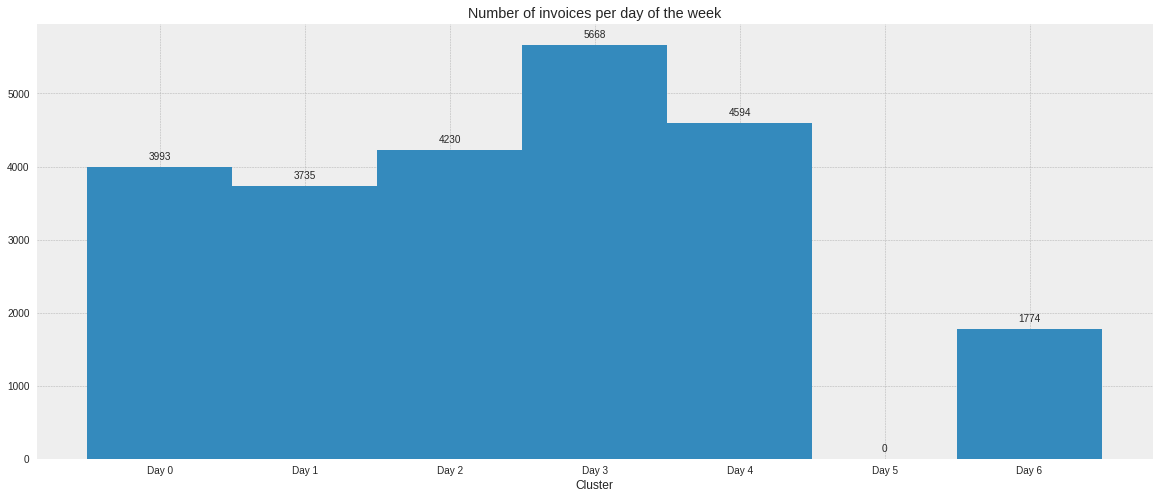

In [0]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [0]:
cluster0['Day'].nunique()

31

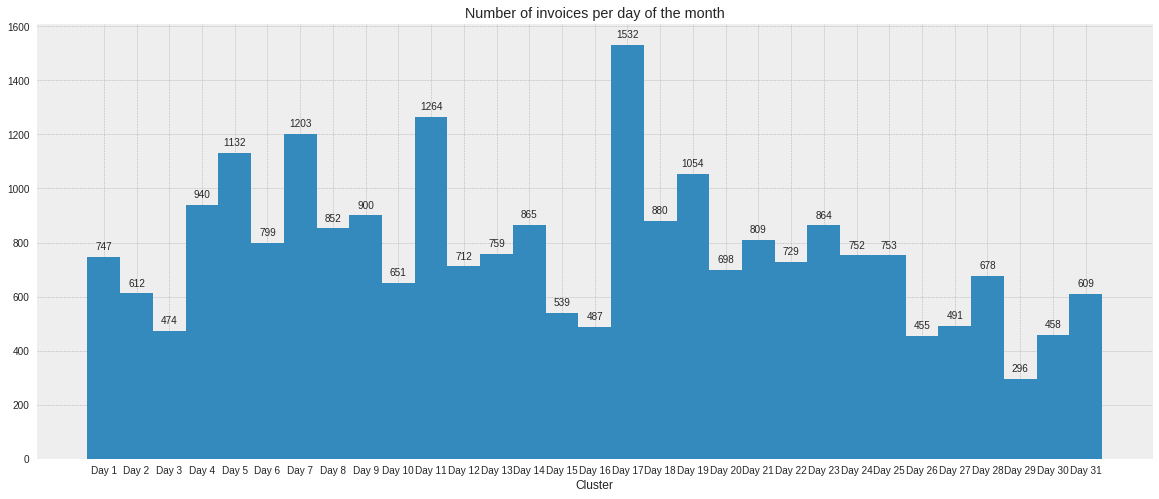

In [0]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [0]:
cluster0['Hour'].nunique()

13

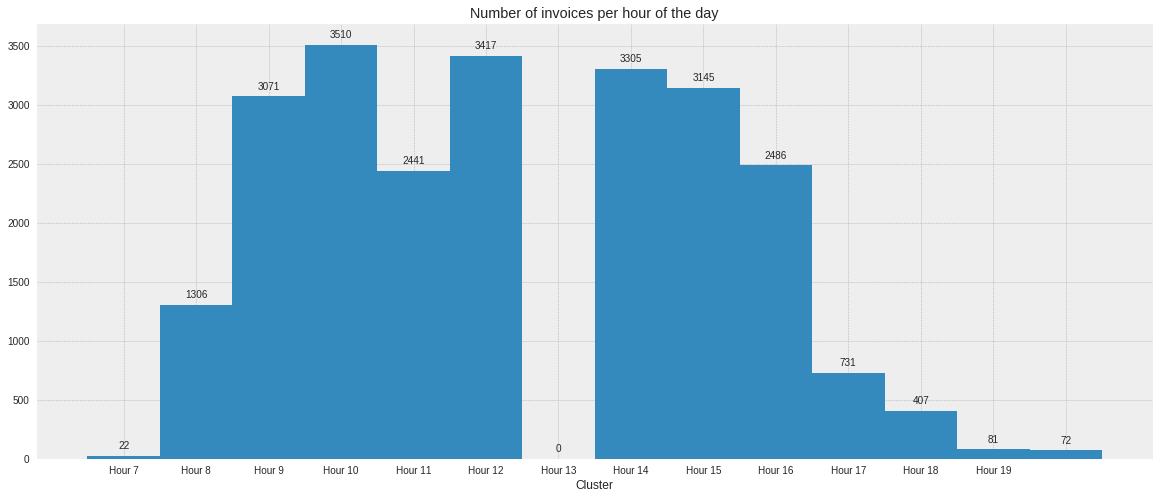

In [0]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster0['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

These customers seems to be good for datazone since they have good RFM scores, the 4 most represented categories are (111, 211, 322, 222). They seem to be normal customers. 


Key figures: 
* Min Basket Price: 10.86
* Mean Basket Price: 30.60
* Max Basket Price: 68.57

* Quantity:            10.00
* UnitPrice:           2.87
* QuantityCanceled:     0.04
* TotalPrice:           17.09
* Frequency           11.134050
* Recency         24.574626

TOP 10 bought products :

* WHITE HANGING HEART T-LIGHT HOLDER:    1345
* JUMBO BAG RED RETROSPOT:               1079
* REGENCY CAKESTAND 3 TIER:               960
* ASSORTED COLOUR BIRD ORNAMENT:          926
* PARTY BUNTING:                          924
* LUNCH BAG RED RETROSPOT:                898
* LUNCH BAG  BLACK SKULL:                753
* SET OF 3 CAKE TINS PANTRY DESIGN:       725
* LUNCH BAG CARS BLUE:                    679
* LUNCH BAG PINK POLKADOT:                676

**2.4.2 Cluster 1**

I already have done all the same analysis for the other clusters, so I won't put all of the code here but the idea is the same

This cluster represents almost lost customers. The weird part about them is that there are some months when they didn't shop at all, it looks like a pattern. 


Key figures: 
* Min Basket Price: 20.83
* Mean Basket Price: 33.77
* Max Basket Price: 26.43

* Quantity:            9.06
* UnitPrice:           2.68
* QuantityCanceled:     0.02
* TotalPrice:           13.77
* Frequency            3.065758
* Recency         36.131902

TOP 10 bought products :

* PAPER CHAIN KIT 50'S CHRISTMAS:        267
* BAKING SET 9 PIECE RETROSPOT:          263
* WHITE HANGING HEART T-LIGHT HOLDER:    250
* ASSORTED COLOUR BIRD ORNAMENT:         247
* REX CASH+CARRY JUMBO SHOPPER:          223
* HOT WATER BOTTLE KEEP CALM:            215
* REGENCY CAKESTAND 3 TIER:              208
* RABBIT NIGHT LIGHT:                    200
* GARDENERS KNEELING PAD KEEP CALM:      194
* SPOTTY BUNTING:                        193

**2.4.3 Cluster 2**

The cluster 2 represents the best customers with a high recency which have around 60 visits, a lot of quantity bought on average, a high moneraty value and also a high frequency around 60 visits. These customers must be taken care.
* Min Basket Price : 13
* Mean Basket Price : 513
* Max Basket Price : 3812
* Quantity            117.083422
* UnitPrice             2.830180
* QuantityCanceled      0.069282
* TotalPrice          258.683970
* frequency            67.812655
* min_recency           1.679039

**2.4.4 Cluster 3**

This cluster is full of lost customers. Indeed, as we can see in the month histogramm there are almost no invoices after july. We can see that there are in december but it's december of the past year. So this cluster is pretty bad for datazone, they don't want to have new customers in there. Furthermore they are cheap customers since the mean basket price is 28.91$ ... 



Key figures: 
* Min Basket Price: 24.20
* Mean Basket Price: 28.91
* Max Basket Price: 34.52

* Quantity:            8.25
* UnitPrice:           3.29
* QuantityCanceled:     0.04
* TotalPrice:          15.20
* Frequency             2.606359
* Recency         237.013433

TOP 10 bought products :

* WHITE HANGING HEART T-LIGHT HOLDER:    227
* REGENCY CAKESTAND 3 TIER:              182
* PARTY BUNTING:                         137
* ASSORTED COLOUR BIRD ORNAMENT:         125
* REX CASH+CARRY JUMBO SHOPPER:          103
* SET OF 3 CAKE TINS PANTRY DESIGN:      100
* NATURAL SLATE HEART CHALKBOARD:        100
* JAM MAKING SET WITH JARS:               99
* HEART OF WICKER SMALL:                  98
* HEART OF WICKER LARGE:                  86

**2.4.5 Cluster 4**

This cluster is quiete heterogeneous since there are 17 best customers, 6 lost cheap customers and so on. They do have a high mean basket price of 505 but it's mostly due to the mean quantity they buy (130) because the mean unit price is very low (3.26)

For the time features, what is interesting is that these customers shop less on weekend and they shopped more at the end of the year.

* Min Basket Price : 247
* Mean Basket Price : 505
* Max Basket Price : 1023
* Quantity            130.299145
* UnitPrice             3.264359
* QuantityCanceled      2.332590
* TotalPrice          184.308595

TOP 10 products bought :

* JUMBO BAG RED RETROSPOT :               38
* BLACK RECORD COVER FRAME :            31
* RECORD FRAME 7" SINGLE SIZE :         28
* REGENCY CAKESTAND 3 TIER :           25
* WORLD WAR 2 GLIDERS ASSTD DESIGNS :    24
* WHITE HANGING HEART T-LIGHT HOLDER :   24
* PARTY BUNTING :                        24
* LUNCH BOX I LOVE LONDON :               23
* RED  HARMONICA IN BOX :                23
* CHILLI LIGHTS :                        23

**2.4.6 Cluster 5**

The cluster 5 contains 3 customers which are very much alike. Indeed, they bought only once or twice a few items at a huge quantity. It might be some profesionnals which bought it at discount and will sell back the commodity. Even if they have a high monetary value they're not very interesting for Datazon and we could consider them as lost customers.
* Min Basket Price : 3368
* Mean Basket Price : 3697
* Max Basket Price : 3533
* Quantity            2213.777778
* UnitPrice              2.386667
* QuantityCanceled       0.000000
* TotalPrice          3890.091111
* Frequency              1.666667
* Min_recency          210.888889

**2.4.7 Cluster 6**

What is very specific about this cluster is that there are no customers from UK, it's only foreign countries (Germany, France, Belgium, Italy and Finland).
This cluster is also heterogeneous in terms of RFM since the 2 most represented categories are Best customer and Lost cheap customer. The average basket is very low (33) comparing the ones above but I guess that the more customers we have in a cluster and the more the average customer will be represented which doesn't spent 500$ per transactions like the ones above. 

October and november have the most invoices which isn't surpring approaching Christmas. 

Key figures: 
* Min Basket Price: 20.58
* Mean Basket Price: 33.55
* Max Basket Price: 59.31

* Quantity:            13.785663
* UnitPrice:           2.884687
* QuantityCanceled:     0.057975
* TotalPrice:          23.749951
* Frequency            7.865563
* Recency         46.622343

TOP 10 bought products :

* ROUND SNACK BOXES SET OF4 WOODLAND:     233
* REGENCY CAKESTAND 3 TIER:               161
* PLASTERS IN TIN WOODLAND ANIMALS:       150
* ROUND SNACK BOXES SET OF 4 FRUITS:      146
* RED TOADSTOOL LED NIGHT LIGHT:          144
* PLASTERS IN TIN CIRCUS PARADE:          141
* SPACEBOY LUNCH BOX:                     137
* RABBIT NIGHT LIGHT:                     120
* PLASTERS IN TIN SPACEBOY:               120
* WOODLAND CHARLOTTE BAG:                 111

**2.4.8 Cluster 7**

The cluster 7 contains 19 customers who are considered as best customers since they by the most, very frequently (75) and recently. The difference with cluster 2 is that they cluster 7's customers buy more frequently (75 vs 60) but have a lower monetary value (58000 vs 249000).
They have a mean basket price lower than the other clusters.

* Min Basket Price : 10
* Mean Basket Price : 138
* Max Basket Price : 648
* Quantity            23.257769
* UnitPrice            2.615444
* QuantityCanceled     0.109129
* TotalPrice          34.916436
* Frequency           121.570291
* Recency           2.599109

TOP 10 products bought :

* REGENCY CAKESTAND 3 TIER:              136
* JUMBO BAG RED RETROSPOT:               135
* WHITE HANGING HEART T-LIGHT HOLDER:    121
* CHILLI LIGHTS:                         102
* PAPER BUNTING RETROSPOT:                97
* LUNCH BAG  BLACK SKULL:                95
* GUMBALL COAT RACK:                      93
* LUNCH BAG RED RETROSPOT:                91
* JUMBO BAG PINK POLKADOT:                84
* LUNCH BAG CARS BLUE:                    81

**2.4.9 Conclusion**

Let's quickly classify the clusters in terms of importance to Datazon :

- Cluster 2: high frequency with a lot of quantity (mean basket price of 513) bought on average and high monetary value (VIP clients)
- Cluster 7 : very high purchase frequency with a mean basket price of 150 but good monetary value.
- Cluster 4: very high basket price (huge quantity of products bought on average)
- Cluster 0: good average customers 
- Cluster 6: good foreign customers 
- Cluster 1: almost lost customers
- Cluster 5: highest monetary value but only one or two purchases over the year 
- Cluster 3: lost customers 

**3. Testing models for prediction**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import datetime as dt
import pickle
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
new_df = pd.read_csv("final_dataset_V2.csv")

In [0]:
new_df.head(5)

,CustomerID,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
0,12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16,...,0.000000,0.0,0.052343,0.0,0.0,0.000000,0.0,0.0,0.002367,0.0
2,12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18,...,0.013914,0.0,0.006861,0.0,0.0,0.086282,0.0,0.0,0.018552,0.0
4,12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


Let's prepare the features

In [0]:
X = new_df.drop(columns=['CustomerID', 'cluster']) 
y = new_df['cluster'].values

In [0]:
scaler = StandardScaler() # create scaler object

X_scaled = scaler.fit_transform(X)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size = 0.2,random_state = 0, stratify=y) # Do 80/20 split

**3.1 Testing classic models**

**3.1.1 Baseline**

In [0]:
from sklearn.dummy import DummyClassifier

In [0]:
dummy_biased = DummyClassifier(random_state=0)

dummy_biased.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=0, strategy='stratified')

In [0]:
print("Baseline accuracy", (dummy_biased.score(X_test, y_test))*100)

Baseline accuracy 29.06574394463668


**3.1.2 Linear models**

In [0]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [0]:
# logistic regression

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("LogisticRegression_classifier accuracy:", (lr.score(X_test, y_test))*100)

LogisticRegression_classifier accuracy: 96.30911188004615


In [0]:
# SGD Classifier

SGD = SGDClassifier()
SGD.fit(X_train, y_train)
print("SGDClassifier accuracy:", (SGD.score(X_test, y_test))*100)

SGDClassifier accuracy: 92.96424452133795


**3.1.3 SVM**

In [0]:
# Linear SVC

from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train, y_train)
print("LinearSVC accuracy:", (svc.score(X_test, y_test))*100)

LinearSVC accuracy: 95.73241061130334


**3.2 Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rfc=RandomForestClassifier(random_state=0, n_estimators = 1000)

In [0]:
param_grid = { 
    'n_estimators' : [100, 500, 1000],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 6],
    'criterion' :['gini', 'entropy']
}

CV_rfc_biased = model_selection.GridSearchCV(estimator=rfc_biased, param_grid=param_grid, cv= 5, verbose=10, n_jobs=-1, scoring='accuracy')
CV_rfc_biased.fit(X_train_biased, y_train_biased)

CV_rfc_random.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 1000}

In [0]:
rfc=RandomForestClassifier(random_state=0, n_estimators = 1000, criterion='entropy', max_depth=6, max_features='auto')

In [0]:
rfc.fit(X_train, y_train)
print("Accuracy for Random Forest Classifier:", (rfc.score(X_test, y_test)*100))

Accuracy for Random Forest Classifier: 94.11764705882352


In [0]:
y_pred = rfc.predict(X_test)

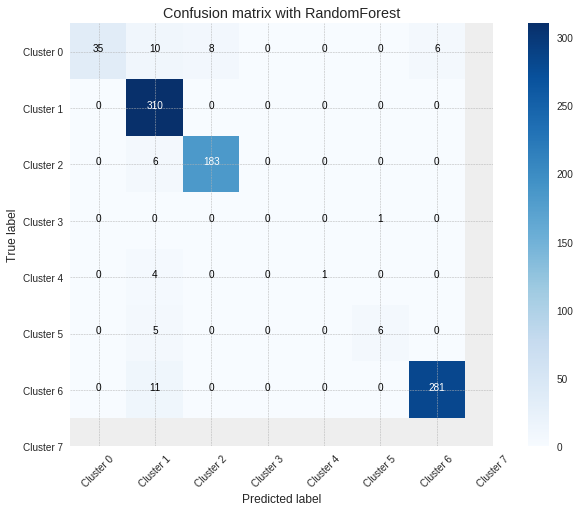

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = ["Cluster {}".format(x) for x in range(8)]

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix with RandomForest')

**3.3 XGBoost**

In [0]:
import xgboost

In [0]:
xgb = xgboost.XGBClassifier(random_state = 0, learning_rate = 0.01, 
                                   objective = 'multi:softprob', n_estimators = 1000,
                                  colsample_bytree = 0.6, gamma = 0.5, max_depth = 7,
                                  min_child_weight = 1, subsample=0.8, n_jobs=-1, scoring='accuracy')

In [0]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.5, learning_rate=0.01,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=-1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, scoring='accuracy', seed=None,
       silent=True, subsample=0.8)

In [0]:
print("Accuracy for XGBoost : ", (xgb.score(X_test, y_test))*100)

Accuracy for XGBoost :  98.96193771626297


In [0]:
y_pred = xgb.predict(X_test)

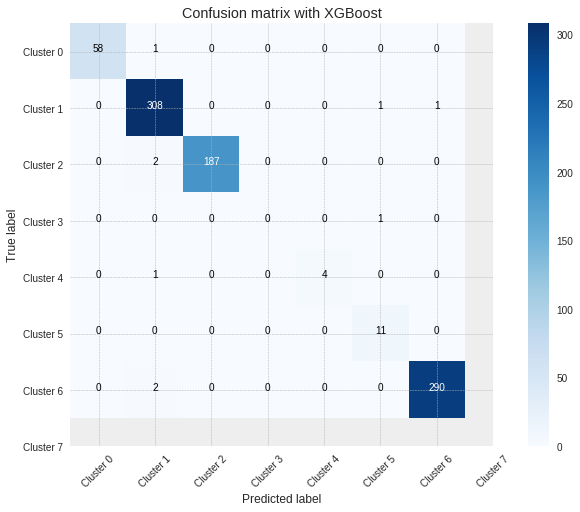

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix with XGBoost')

In [0]:
# Saving the best estimator 

with open('training_algos.pickle', 'wb') as f:
    pickle.dump(xgb, f)

In [0]:
df = pd.read_csv("data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [0]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [0]:
df = df.sort_values(by=['CustomerID'])

In [0]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346,United Kingdom
286628,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,8/2/2011 8:48,2.25,12347,Iceland
72263,542237,47559B,TEA TIME OVEN GLOVE,10,1/26/2011 14:30,1.25,12347,Iceland
72264,542237,21154,RED RETROSPOT OVEN GLOVE,10,1/26/2011 14:30,1.25,12347,Iceland
72265,542237,21041,RED RETROSPOT OVEN GLOVE DOUBLE,6,1/26/2011 14:30,2.95,12347,Iceland
72266,542237,21035,SET/2 RED RETROSPOT TEA TOWELS,6,1/26/2011 14:30,2.95,12347,Iceland
72267,542237,22423,REGENCY CAKESTAND 3 TIER,3,1/26/2011 14:30,12.75,12347,Iceland
72268,542237,84969,BOX OF 6 ASSORTED COLOUR TEASPOONS,6,1/26/2011 14:30,4.25,12347,Iceland
72269,542237,22134,MINI LADLE LOVE HEART RED,12,1/26/2011 14:30,0.42,12347,Iceland
